Libraries and functions

yields: 
 y1    4.90
y2    5.09
y3    5.26
y4    5.41
y5    5.52
dtype: float64


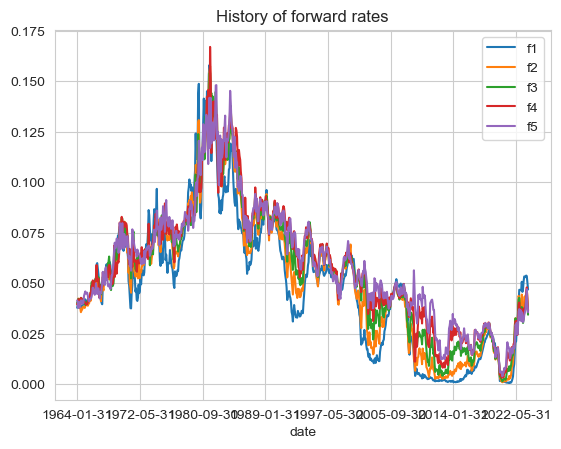

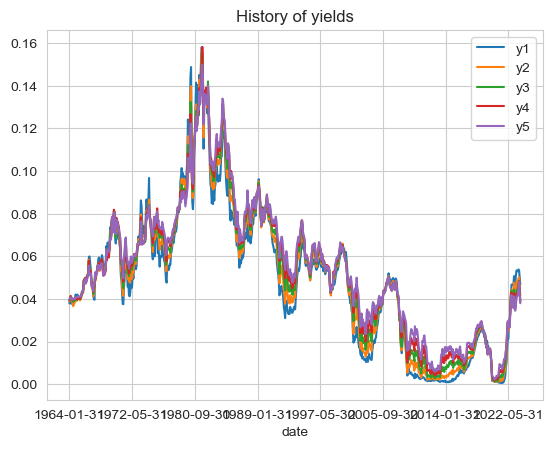

In [2]:

import numpy as np # matrix algebra
import matplotlib.pyplot as plt # plotting
import pandas as pd # data frames
import datetime as dt # time
import scipy.stats as st # statistics
import statsmodels.api as sm # regression models

import numpy.linalg as la # submodule for linear algebra (e.g. inverse)

# not necessary, but gives nicer graph settings https://seaborn.pydata.org/
import seaborn as sns
sns.set_style("whitegrid")

import functions1 as f1 # own functions

fama_bliss_file = "fb.csv"
fb = pd.read_csv(fama_bliss_file, header=1)
fb.columns = ['date', 'yield1', 'yield2', 'yield3', 'yield4', 'yield5']

# set the index
fb.set_index('date', inplace=True)
# use the Fama-Bliss data from 1964; transform to percentages
data = fb['1964-01-01':'2023-12-31'] / 100

# compute continuously compounding yields and log prices
for i in range(1, 6):
    data[f'P{i}'] = np.exp(-data[f'yield{i}'] * i)
    data[f'p{i}'] = np.log(data[f'P{i}'])
    data[f'y{i}'] = -data[f'p{i}'] / i

# forwards
data['f1'] = data['y1']
for i in range(2, 6):
    data[f'f{i}'] = data[f'p{i-1}'] - data[f'p{i}']

print('yields: \n',
      np.round(data[['y1', 'y2', 'y3', 'y4', 'y5']].mean()*100, 2))

n = data.shape[0]

# make a simple plot from a data frame
data[['f1', 'f2', 'f3', 'f4', 'f5']].plot(grid=True,
                                          title="History of forward rates")
plt.show()

# make a simple plot from a data frame
data[['y1', 'y2', 'y3', 'y4', 'y5']].plot(grid=True,
                                          title="History of yields")
plt.show()



Start of analysis, (1) up to (3)

In [4]:
# create prices and holding period returns
data['P1_lag'] = data['P1'].shift(1)
data['HPR1'] = data['P1'] / data['P1_lag'] - 1

for i in range(2, 6):
    data[f'P{i}_lag'] = data[f'P{i}'].shift(1)
    data[f'HPR{i}'] = data[f'P{i}'] / data[f'P{i}_lag'] - 1

# drop rows with NaN values created by shifting
data.dropna(inplace=True)

print(data[['HPR1', 'HPR2', 'HPR3', 'HPR4', 'HPR5']].head())

# compute excess returns
for i in range(1, 6):
    data[f'excess_return{i}'] = data[f'HPR{i}'] - data[f'yield{i}']

# display the first few rows of the excess returns
print(data[[f'excess_return{i}' for i in range(1, 6)]].head())

# compute forward rates
for i in range(2, 6):
    data[f'f{i}'] = data[f'p{i-1}'] - data[f'p{i}']

# display the first few rows of the forward rates
print(data[[f'f{i}' for i in range(1, 6)]].head())


                HPR1      HPR2      HPR3      HPR4      HPR5
date                                                        
1964-03-31  0.000370 -0.001903 -0.003001 -0.005368 -0.002482
1964-04-30  0.001276  0.001966  0.002334  0.002512 -0.000208
1964-05-28 -0.000493  0.001201  0.002498  0.002446  0.004893
1964-06-30  0.000527  0.002797  0.002121  0.001948  0.000098
1964-07-31  0.000207  0.002294  0.000759  0.000081 -0.001431
            excess_return1  excess_return2  excess_return3  excess_return4  \
date                                                                         
1964-03-31       -0.038735       -0.042667       -0.044252       -0.046817   
1964-04-30       -0.036553       -0.037815       -0.038139       -0.038310   
1964-05-28       -0.038816       -0.037981       -0.037143       -0.037765   
1964-06-30       -0.037268       -0.034988       -0.036814       -0.037777   
1964-07-31       -0.037381       -0.034346       -0.037923       -0.039624   

            excess_return5

Versie prof

In [5]:
p = data[['p1', 'p2', 'p3', 'p4', 'p5']].values
# p^{(n)}_{t+1} - p^{(n-1)}_t measured anually
# for the holding period returns
r_n = p[12:, 0:4] - p[:-12, 1:5]
# compute excess holding period returns
# r^{(n)}_{t+1} - y^{(1)}_t
rx_n = r_n - np.kron(data['y1'].values[:-12],
                     np.ones(4)).reshape(n-12, 4)

rx_n_mean = rx_n.mean(axis=0)
rx_n_std = rx_n.std(axis=0)
rx_sr = rx_n_mean / rx_n_std


rx_n_mean = 0.05 * np.ones(4)
rx_n_std = 0.02 * np.ones(4)
rx_sr = 2.5 * np.ones(4)

sharpe_ratios = pd.DataFrame(np.array([rx_n_mean*10000.0,
                                       rx_n_std*10000.0,
                                       rx_sr]).T,
                             index=['SR2', 'SR3', 'SR4', 'SR5'],
                             columns=['E[rx]', 'sigma[rx]', 'SR'])

print(np.round(sharpe_ratios, 2))

ValueError: cannot reshape array of size 2824 into shape (708,4)

solving shape of array issue, deze code is juist

In [6]:
# Extract price matrix
p = data[['p1', 'p2', 'p3', 'p4', 'p5']].values

# Compute holding period returns (annualized)
r_n = p[12:, 0:4] - p[:-12, 1:5]  # Shape (T-12, 4)

# Compute excess holding period returns: r^{(n)}_{t+1} - y^{(1)}_t
rx_n = r_n - np.tile(data['y1'].values[:-12].reshape(-1, 1), 4)  # Shape (T-12, 4)

# Compute mean, std, and Sharpe ratio
rx_n_mean = rx_n.mean(axis=0)  # Expected excess returns
rx_n_std = rx_n.std(axis=0)    # Standard deviation of excess returns
rx_sr = rx_n_mean / rx_n_std   # Sharpe ratios

# we delete fixed value inputs and replace them with the computed values

# Create DataFrame for Sharpe ratios
sharpe_ratios = pd.DataFrame(
    np.array([rx_n_mean * 10000.0, rx_n_std * 10000.0, rx_sr]).T,
    index=['SR2', 'SR3', 'SR4', 'SR5'],
    columns=['E[rx]', 'sigma[rx]', 'SR']
)

# Print results
print(np.round(sharpe_ratios, 2))


      E[rx]  sigma[rx]    SR
SR2   38.27     172.17  0.22
SR3   71.46     315.97  0.23
SR4  100.49     439.64  0.23
SR5  108.80     544.00  0.20


In [9]:

# 3. Estimate the Fama-Bliss regressions and report a, b, R2, se(a), se(b) for n = 2, 3, 4, 5
# first version
results = {}

for n in range(2, 6):
    # Define the dependent and independent variables for the first regression
    rx_nt1 = data[f'excess_return{n}']
    f_n_y1 = data[f'f{n}'] - data['y1']
    
    # Fit the first regression model
    X1 = sm.add_constant(f_n_y1)
    model1 = sm.OLS(rx_nt1, X1).fit()
    
    # Define the dependent and independent variables for the second regression
    y1_tn1_y1 = data['y1'].shift(-n+1) - data['y1']
    y1_tn1_y1 = y1_tn1_y1.dropna()
    f_n_y1_shifted = f_n_y1.shift(-n+1).dropna()
    
    # Fit the second regression model
    X2 = sm.add_constant(f_n_y1_shifted)
    model2 = sm.OLS(y1_tn1_y1, X2).fit()
    
    # Store the results
    results[n] = {
        'a_x': model1.params['const'],
        'b_x': model1.params[0],
        'R2_x': model1.rsquared,
        'se(a_x)': model1.bse['const'],
        'se(b_x)': model1.bse[0],
        'a_y': model2.params['const'],
        'b_y': model2.params[0],
        'R2_y': model2.rsquared,
        'se(a_y)': model2.bse['const'],
        'se(b_y)': model2.bse[0]
    }

# Display the results
for n in results:
    print(f"Results for n = {n}:")
    print(f"a_x: {results[n]['a_x']}, b_x: {results[n]['b_x']}, R2_x: {results[n]['R2_x']}, se(a_x): {results[n]['se(a_x)']}, se(b_x): {results[n]['se(b_x)']}")
    print(f"a_y: {results[n]['a_y']}, b_y: {results[n]['b_y']}, R2_y: {results[n]['R2_y']}, se(a_y): {results[n]['se(a_y)']}, se(b_y): {results[n]['se(b_y)']}")
    print()

Results for n = 2:
a_x: -0.05213039856415713, b_x: 0.3340918530390934, R2_x: 0.00463564917340753, se(a_x): 0.00145966126632547, se(b_x): 0.18295535889547124
a_y: 0.0003508040729115688, b_y: -0.08997472040649562, R2_y: 0.01874686442827045, se(a_y): 0.0001943349741849453, se(b_y): 0.02434409837139197

Results for n = 3:
a_x: -0.056751866305828125, b_x: 0.6027273795068415, R2_x: 0.03139804116661915, se(a_x): 0.001556441901708454, se(b_x): 0.12510820793890204
a_y: 0.001112651170684597, b_y: -0.15463505274141726, R2_y: 0.05222179192236032, se(a_y): 0.0003071060736348239, se(b_y): 0.024653938902342992

Results for n = 4:
a_x: -0.059598332769850194, b_x: 0.568470317518041, R2_x: 0.04003593277188355, se(a_x): 0.0016645579114077473, se(b_x): 0.10402884934595825
a_y: 0.0018027077591624486, b_y: -0.1784620816032516, R2_y: 0.06974044173302729, se(a_y): 0.00039135461693158097, se(b_y): 0.024409614068624786

Results for n = 5:
a_x: -0.062103565180532755, b_x: 0.6699022226483045, R2_x: 0.067909000125

In [10]:
# 3. Estimate the Fama-Bliss regressions and report a, b, R2, se(a), se(b) for n = 2, 3, 4, 5

# second version
# Define the regression function
def regression(forwards, yield1, rx):
    """ """
    X = forwards - yield1
    X = sm.add_constant(X)
    results = sm.OLS(rx, X).fit()
    return results


# Estimate the Fama-Bliss regressions and report a, b, R2, se(a), se(b) for n = 2, 3, 4, 5
results = {}

for n in range(2, 6):
    # Define the dependent and independent variables for the first regression
    rx_nt1 = data[f'excess_return{n}']
    f_n_y1 = data[f'f{n}'] - data['y1']
    
    # Fit the first regression model
    model1 = regression(data[f'f{n}'], data['y1'], rx_nt1)
    
    # Define the dependent and independent variables for the second regression
    y1_tn1_y1 = data['y1'].shift(-n+1) - data['y1']
    y1_tn1_y1 = y1_tn1_y1.dropna()
    f_n_y1_shifted = f_n_y1.shift(-n+1).dropna()
    
    # Fit the second regression model
    model2 = regression(f_n_y1_shifted, data['y1'].shift(-n+1).dropna(), y1_tn1_y1)
    
    # Store the results
    results[n] = {
        'a_x': model1.params['const'],
        'b_x': model1.params[0],
        'R2_x': model1.rsquared,
        'se(a_x)': model1.bse['const'],
        'se(b_x)': model1.bse[0],
        'a_y': model2.params['const'],
        'b_y': model2.params[0],
        'R2_y': model2.rsquared,
        'se(a_y)': model2.bse['const'],
        'se(b_y)': model2.bse[0]
    }

# Display the results
for n in results:
    print(f"Results for n = {n}:")
    print(f"a_x: {results[n]['a_x']}, b_x: {results[n]['b_x']}, R2_x: {results[n]['R2_x']}, se(a_x): {results[n]['se(a_x)']}, se(b_x): {results[n]['se(b_x)']}")
    print(f"a_y: {results[n]['a_y']}, b_y: {results[n]['b_y']}, R2_y: {results[n]['R2_y']}, se(a_y): {results[n]['se(a_y)']}, se(b_y): {results[n]['se(b_y)']}")
    print()


Results for n = 2:
a_x: -0.05213039856415713, b_x: 0.3340918530390934, R2_x: 0.00463564917340753, se(a_x): 0.00145966126632547, se(b_x): 0.18295535889547124
a_y: -0.0005373866685349598, b_y: -0.012118532334858295, R2_y: 0.008547092843995685, se(a_y): 0.00027997653447950073, se(b_y): 0.004881168945388713

Results for n = 3:
a_x: -0.056751866305828125, b_x: 0.6027273795068415, R2_x: 0.03139804116661915, se(a_x): 0.001556441901708454, se(b_x): 0.12510820793890204
a_y: -0.0011443660338813564, b_y: -0.027900590213079557, R2_y: 0.02328506074477177, se(a_y): 0.0003836013531498064, se(b_y): 0.006762534788085888

Results for n = 4:
a_x: -0.059598332769850194, b_x: 0.568470317518041, R2_x: 0.04003593277188355, se(a_x): 0.0016645579114077473, se(b_x): 0.10402884934595825
a_y: -0.0015205945097113464, b_y: -0.040023563630414614, R2_y: 0.035533173948325225, se(a_y): 0.0004393346565887284, se(b_y): 0.0078090397960119745

Results for n = 5:
a_x: -0.062103565180532755, b_x: 0.6699022226483045, R2_x: 0.

In [11]:
# 4. Correct for overlapping samples using Newey-West standard errors and test the expectation hypothesis

# Define the regression function with Newey-West standard errors
def regression_newey_west(forwards, yield1, rx, lag=12):
    """ """
    X = forwards - yield1
    X = sm.add_constant(X)
    results = sm.OLS(rx, X).fit(cov_type='HAC', cov_kwds={'maxlags': 1})
    return results

# Estimate the Fama-Bliss regressions with Newey-West standard errors and test the expectation hypothesis
results_newey_west = {}

for n in range(2, 6):
    # Define the dependent and independent variables for the first regression
    rx_nt1 = data[f'excess_return{n}']
    f_n_y1 = data[f'f{n}'] - data['y1']
    
    # Fit the first regression model with Newey-West standard errors
    model1_nw = regression_newey_west(data[f'f{n}'], data['y1'], rx_nt1)
    
    # Define the dependent and independent variables for the second regression
    y1_tn1_y1 = data['y1'].shift(-n+1) - data['y1']
    y1_tn1_y1 = y1_tn1_y1.dropna()
    f_n_y1_shifted = f_n_y1.shift(-n+1).dropna()
    
    # Fit the second regression model with Newey-West standard errors
    model2_nw = regression_newey_west(f_n_y1_shifted, data['y1'].shift(-n+1).dropna(), y1_tn1_y1)
    
    # Store the results
    results_newey_west[n] = {
        'a_x': model1_nw.params['const'],
        'b_x': model1_nw.params[0],
        'R2_x': model1_nw.rsquared,
        'se(a_x)': model1_nw.bse['const'],
        'se(b_x)': model1_nw.bse[0],
        'a_y': model2_nw.params['const'],
        'b_y': model2_nw.params[0],
        'R2_y': model2_nw.rsquared,
        'se(a_y)': model2_nw.bse['const'],
        'se(b_y)': model2_nw.bse[0]
    }

# Display the results with Newey-West standard errors
for n in results_newey_west:
    print(f"Results for n = {n} with Newey-West standard errors:")
    print(f"a_x: {results_newey_west[n]['a_x']}, b_x: {results_newey_west[n]['b_x']}, R2_x: {results_newey_west[n]['R2_x']}, se(a_x): {results_newey_west[n]['se(a_x)']}, se(b_x): {results_newey_west[n]['se(b_x)']}")
    print(f"a_y: {results_newey_west[n]['a_y']}, b_y: {results_newey_west[n]['b_y']}, R2_y: {results_newey_west[n]['R2_y']}, se(a_y): {results_newey_west[n]['se(a_y)']}, se(b_y): {results_newey_west[n]['se(b_y)']}")
    print()


# Test the expectation hypothesis for all cases
for n in range(2, 6):
    # Test the hypothesis that b_x = 0
    t_stat_b_x = results_newey_west[n]['b_x'] / results_newey_west[n]['se(b_x)']
    p_value_b_x = 2 * (1 - st.norm.cdf(np.abs(t_stat_b_x)))
    
    # Test the hypothesis that b_y = 1
    t_stat_b_y = (results_newey_west[n]['b_y'] - 1) / results_newey_west[n]['se(b_y)']
    p_value_b_y = 2 * (1 - st.norm.cdf(np.abs(t_stat_b_y)))
    
    print(f"Expectation hypothesis test results for n = {n}:")
    print(f"t-statistic for b_x: {t_stat_b_x}, p-value: {p_value_b_x}")
    print(f"t-statistic for b_y: {t_stat_b_y}, p-value: {p_value_b_y}")
    print()


Results for n = 2 with Newey-West standard errors:
a_x: -0.05213039856415713, b_x: 0.3340918530390934, R2_x: 0.00463564917340753, se(a_x): 0.0021671485052011277, se(b_x): 0.27954331033273205
a_y: -0.0005373866685349598, b_y: -0.012118532334858295, R2_y: 0.008547092843995685, se(a_y): 0.0002686915984464839, se(b_y): 0.008131409191705958

Results for n = 3 with Newey-West standard errors:
a_x: -0.056751866305828125, b_x: 0.6027273795068415, R2_x: 0.03139804116661915, se(a_x): 0.0022902897100163535, se(b_x): 0.18528975190296557
a_y: -0.0011443660338813564, b_y: -0.027900590213079557, R2_y: 0.02328506074477177, se(a_y): 0.0003747488860082219, se(b_y): 0.011612827075485105

Results for n = 4 with Newey-West standard errors:
a_x: -0.059598332769850194, b_x: 0.568470317518041, R2_x: 0.04003593277188355, se(a_x): 0.002363831922716641, se(b_x): 0.15045879576662885
a_y: -0.0015205945097113464, b_y: -0.040023563630414614, R2_y: 0.035533173948325225, se(a_y): 0.00043802110378881904, se(b_y): 0.013